## Notebook for creating evaluation plots
Note: To run this notebook, please install the ipykernel package.

In [152]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [153]:
def draw_plus_symbol(image, y, x, size=6, thickness=1):
    # Calculate the coordinates of the plus symbol
    x_start = max(0, x - size)
    x_end = min(image.shape[1], x + size + 1)
    y_start = max(0, y - thickness // 2)
    y_end = min(image.shape[0], y + thickness // 2 + 1)

    # Draw horizontal line
    image[y_start:y_end, x_start:x_end] = [0, 0, 1]

    # Calculate the coordinates of the vertical line
    y_start = max(0, y - size)
    y_end = min(image.shape[0], y + size + 1)
    x_start = max(0, x - thickness // 2)
    x_end = min(image.shape[1], x + thickness // 2 + 1)

    # Draw vertical line
    image[y_start:y_end, x_start:x_end] = [0, 0, 1]

    return image


In [154]:
def normalize_array(array, min_val=0, max_val=1):
    # Find the minimum and maximum values in the array
    array_min = np.min(array)
    array_max = np.max(array)
    
    # Normalize the array between min_val and max_val
    normalized_array = min_val + (array - array_min) * (max_val - min_val) / (array_max - array_min)
    
    return normalized_array

### Evaluation of the VarNet result

In [155]:
# Define coordinates of ROI
x_index = 80
y_index = 195
# Define number of spokes for spatial resolution and resulting time frames
n_spokes = 13
n_frames = 22

In [156]:
file = h5py.File('../runs/base_varnet_layer-03_iter-05_epoch-040_loss-MSE_optim-Adam_lr-0.010000/test/recon_001.h5', "r")
# Return datasets as a numpy array
gt = file['gt'][()]
recon = file['recon'][()]

In [157]:
imgs = [Image.fromarray(img) for img in normalize_array(gt[0, :, :, :], 0, 255)]
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

<img src="array.gif" width="250" align="center">

In [158]:
# Sum over the time dimension and squeeze the arrays
summed_gt = np.squeeze(np.sum(gt, axis=1))
summed_recon = np.squeeze(np.sum(recon, axis=1))

# Normalize both arrays
summed_gt = normalize_array(summed_gt)
gt = normalize_array(gt)
summed_recon = normalize_array(summed_recon)
recon = normalize_array(recon)

In [159]:
# Add color dimension and draw ROI
summed_gt = np.repeat(summed_gt[:, :, np.newaxis], 3, axis=2)
summed_gt = draw_plus_symbol(summed_gt, x_index, y_index)

summed_recon = np.repeat(summed_recon[:, :, np.newaxis], 3, axis=2)
summed_recon = draw_plus_symbol(summed_recon, x_index, y_index)

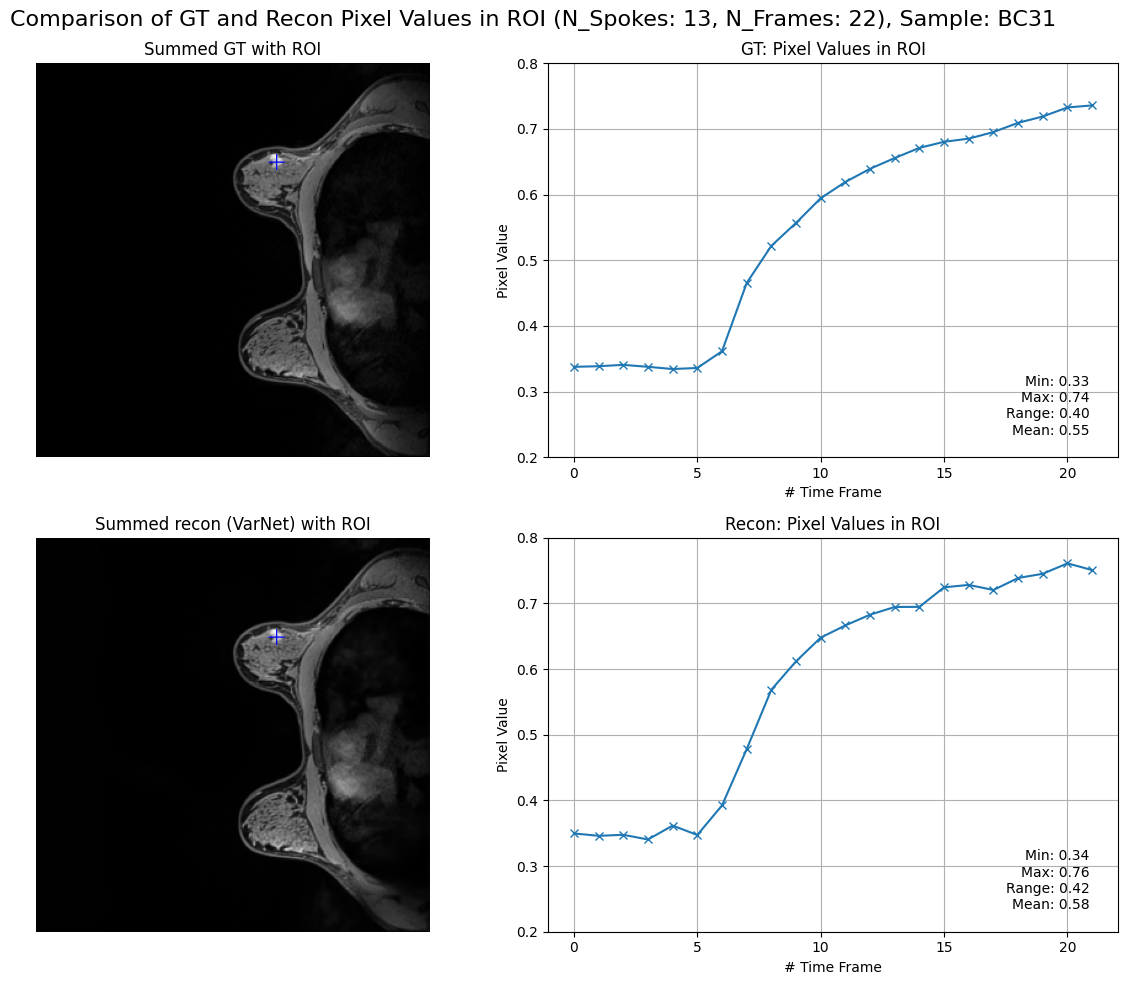

In [178]:
# Create a new figure
plt.figure(figsize=(12, 10))

# Add a large title above all subfigures
plt.suptitle(f'Comparison of GT and Recon Pixel Values in ROI (N_Spokes: {n_spokes}, N_Frames: {n_frames}), Sample: BC31', fontsize=16)

# Plot 1: Summed gt with ROI
plt.subplot(2, 2, 1)
plt.imshow(summed_gt)
plt.title('Summed GT with ROI')
plt.axis('off')

# Plot 2: Gt Pixel Values in ROI
plt.subplot(2, 2, 2)
pixel_values = gt[0, :, x_index, y_index]
plt.plot(pixel_values, '-x')
plt.title('GT: Pixel Values in ROI')
plt.xlabel('# Time Frame')
plt.ylabel('Pixel Value')
plt.yticks(np.arange(0.2, 0.9, 0.1))
min_val = pixel_values.min()
max_val = pixel_values.max()
range_val = max_val - min_val
mean_val = np.mean(pixel_values)
plt.text(0.95, 0.05, f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nRange: {range_val:.2f}\nMean: {mean_val:.2f}",
         horizontalalignment='right', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=10)
plt.grid(True)

# Plot 3: Summed recon (VarNet) with ROI
plt.subplot(2, 2, 3)
plt.imshow(summed_recon)
plt.title('Summed recon (VarNet) with ROI')
plt.axis('off')

# Plot 4: Recon Pixel Values in ROI
plt.subplot(2, 2, 4)
pixel_values = recon[0, :, x_index, y_index]
plt.plot(pixel_values, '-x')
plt.title('Recon: Pixel Values in ROI')
plt.xlabel('# Time Frame')
plt.ylabel('Pixel Value')
plt.yticks(np.arange(0.2, 0.9, 0.1))
min_val = pixel_values.min()
max_val = pixel_values.max()
range_val = max_val - min_val
mean_val = np.mean(pixel_values)
plt.text(0.95, 0.05, f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nRange: {range_val:.2f}\nMean: {mean_val:.2f}",
         horizontalalignment='right', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=10)
plt.grid(True)


# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

### Evaluation of the TV recon

In [161]:
# Load recons, squeeze them and take absolute value
radialx_tv = np.load('radialx_tv.npz')
radialx_tv_p3 = np.abs(np.squeeze(radialx_tv['radialx_tv_p3']))
radialx_tv_p7 = np.abs(np.squeeze(radialx_tv['radialx_tv_p7']))
radialx_tv_p1 = np.abs(np.squeeze(radialx_tv['radialx_tv_p1']))
print(f'Shape of radialx_tv: {radialx_tv_p3.shape}')

Shape of radialx_tv: (22, 320, 320)


In [162]:
# Rotate each channel of the image by 90 degrees counter-clockwise
radialx_tv_p3 = np.array([np.rot90(channel, k=1) for channel in radialx_tv_p3])
radialx_tv_p7 = np.array([np.rot90(channel, k=1) for channel in radialx_tv_p7])
radialx_tv_p1 = np.array([np.rot90(channel, k=1) for channel in radialx_tv_p1])

In [163]:
# Sum over the time dimension and normalize the arrays
summed_radialx_tv_p3 = normalize_array(np.sum(radialx_tv_p3, axis=0))
summed_radialx_tv_p7 = normalize_array(np.sum(radialx_tv_p7, axis=0))
summed_radialx_tv_p1 = normalize_array(np.sum(radialx_tv_p1, axis=0))

# Normalize recons between 0 and 1
radialx_tv_p3 = normalize_array(radialx_tv_p3)
radialx_tv_p7 = normalize_array(radialx_tv_p7)
radialx_tv_p1 = normalize_array(radialx_tv_p1)

In [164]:
# Add color dimension and draw ROI
summed_radialx_tv_p3 = np.repeat(summed_radialx_tv_p3[:, :, np.newaxis], 3, axis=2)
summed_radialx_tv_p3 = draw_plus_symbol(summed_radialx_tv_p3, x_index, y_index)

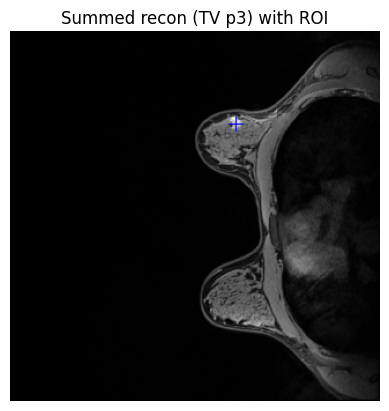

In [165]:
plt.imshow(summed_radialx_tv_p3, cmap='gray')
plt.title('Summed recon (TV p3) with ROI')
plt.axis('off')
plt.show()

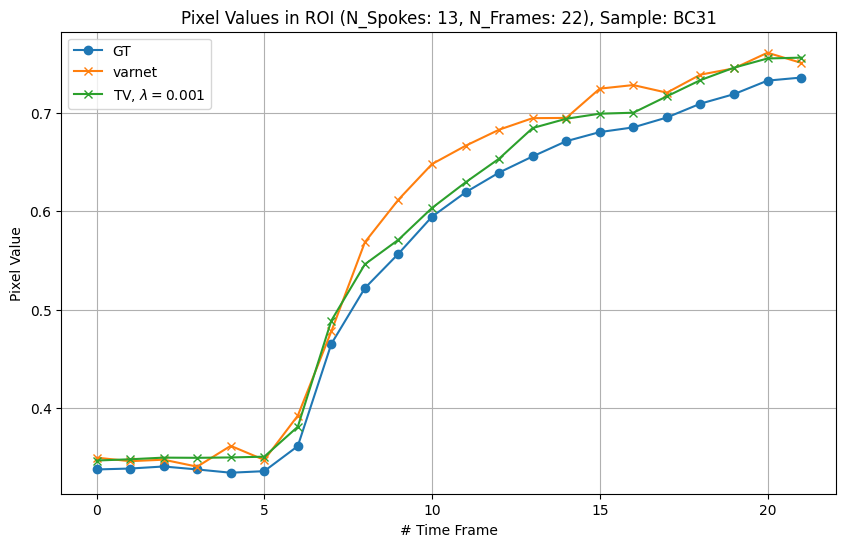

In [177]:
# Create the plot
plt.figure(figsize=(10, 6))  # Optional: set the size of the figure

# Plot each array
gt_values = gt[0, :, x_index, y_index]
plt.plot(gt_values, '-o', label='GT')

varnet_values = recon[0, :, x_index, y_index]
plt.plot(varnet_values, '-x', label='varnet')

tv_p3_values = radialx_tv_p3[:, x_index, y_index]
plt.plot(tv_p3_values, '-x', label=r'TV, $\lambda = 0.001$')

# Add labels and title
plt.xlabel('# Time Frame')
plt.ylabel('Pixel Value')
plt.title(f'Pixel Values in ROI (N_Spokes: {n_spokes}, N_Frames: {n_frames}), Sample: BC31')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()